# Noise Reduction

Reduce background musics, noises and etc while maintain voice activities.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/noise-reduction](https://github.com/huseinzol05/malaya-speech/tree/master/example/noise-reduction).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### Dataset

Trained on English, Manglish and Bahasa podcasts with augmented noises, gathered at https://github.com/huseinzol05/malaya-speech/tree/master/data/podcast

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [2]:
y, sr = malaya_speech.load('speech/podcast/SKOLAR.wav', sr = 44100)
len(y), sr, len(y) / sr

(2628043, 44100, 59.59281179138322)

So total length is 60 seconds.

In [3]:
import IPython.display as ipd
ipd.Audio(y[:10 * sr], rate = sr)

This audio extracted from https://www.youtube.com/watch?v=blaIfSWf38Q&t=25s&ab_channel=SkolarMalaysia

As you can hear, the audio got introduction music overlapped with speakers. So we want to reduce that introduction music and possibly split the audio into voice and background noise.

### List available deep model

In [4]:
malaya_speech.noise_reduction.available_model()

INFO:root:Only calculate SDR, ISR, SAR on voice sample. Higher is better.


Size (MB)  Quantized Size (MB)   SUM MAE  MAE_SPEAKER  MAE_NOISE  \
unet              78.9                 20.0  0.862316     0.460676    0.40164   
resnet-unet       96.4                 24.6  0.825350     0.438850    0.38649   
resnext           75.4                 19.0  0.811020     0.447190    0.36383   

                  SDR       ISR       SAR  
unet         9.173120  13.92435  13.20592  
resnet-unet  9.454130  13.96390  13.60276  
resnext      8.992832  13.49194  13.13210

### Load deep model

```python
def deep_model(model: str = 'resnet-unet', quantized: bool = False, **kwargs):
    """
    Load Noise Reduction deep learning model.

    Parameters
    ----------
    model : str, optional (default='wavenet')
        Model architecture supported. Allowed values:

        * ``'unet'`` - pretrained UNET.
        * ``'resnet-unet'`` - pretrained resnet-UNET.
        * ``'resnext'`` - pretrained resnext-UNET.
    quantized : bool, optional (default=False)
        if True, will load 8-bit quantized model. 
        Quantized model not necessary faster, totally depends on the machine.

    Returns
    -------
    result : malaya_speech.model.tf.UNET_STFT class
    """
```

In [14]:
model = malaya_speech.noise_reduction.deep_model(model = 'resnet-unet')

### Load Quantized deep model

To load 8-bit quantized model, simply pass `quantized = True`, default is `False`.

We can expect slightly accuracy drop from quantized model, and not necessary faster than normal 32-bit float model, totally depends on machine.

In [15]:
quantized_model = malaya_speech.noise_reduction.deep_model(model = 'resnet-unet', quantized = True)

### Important factor

1. Noise Reduction model trained on 44k sample rate, so make sure load the audio with 44k sample rate.

```python
malaya_speech.load(audio_file, sr = 44100)
librosa.load(audio_file, sr = 44100)
```

2. You can feed dynamic length of audio, no need to cap, the model do padding by itself. But again, the longer the audio, the longer time required to calculate, unless you have GPU to speed up.
3. STFT and Inverse STFT can be done on GPU level, so the model is really fast on GPU.

In [7]:
%%time

output = model(y)

CPU times: user 27.3 s, sys: 3.48 s, total: 30.8 s
Wall time: 6.54 s


In [8]:
output

{'voice': array([ 7.4655384e-07, -5.3525662e-07, -3.8191757e-07, ...,
        -3.0058224e-02, -2.9105157e-02, -2.1171883e-02], dtype=float32),
 'noise': array([-4.3224041e-08, -2.3430280e-06, -3.2800205e-07, ...,
        -1.3801644e-03, -3.3497461e-03, -1.9985531e-03], dtype=float32)}

In [9]:
ipd.Audio(output['voice'][:10 * sr], rate = sr)

In [10]:
ipd.Audio(output['noise'][:10 * sr], rate = sr)

Nicely done! How about our quantized model?

In [11]:
%%time

output_quantized = quantized_model(y)
output_quantized

CPU times: user 28.6 s, sys: 3.58 s, total: 32.2 s
Wall time: 8.05 s


{'voice': array([ 6.0242473e-07, -6.7520131e-07, -4.9965337e-07, ...,
        -3.0453464e-02, -2.9502867e-02, -2.1368120e-02], dtype=float32),
 'noise': array([ 1.01274054e-07, -2.20296351e-06, -2.10108894e-07, ...,
        -9.84926941e-04, -2.95203505e-03, -1.80230662e-03], dtype=float32)}

In [12]:
ipd.Audio(output_quantized['voice'][:10 * sr], rate = sr)

In [13]:
ipd.Audio(output_quantized['noise'][:10 * sr], rate = sr)

### Use Pipeline

Incase your audio is too long and you do not want to burden your machine. So, you can use malaya-speech Pipeline to split the audio splitted to 15 seconds, predict one-by-one and combine after that.

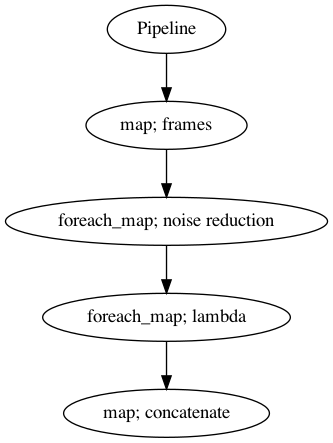

In [16]:
p = Pipeline()
pipeline = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 15000, sample_rate = sr)
    .foreach_map(model)
    .foreach_map(lambda x: x['voice'])
    .map(np.concatenate)
)
p.visualize()

In [17]:
%%time

results = p.emit(y)

CPU times: user 34.8 s, sys: 4.52 s, total: 39.3 s
Wall time: 7.67 s


In [18]:
results.keys()

dict_keys(['frames', 'noise-reduction', '<lambda>', 'concatenate'])

In [19]:
ipd.Audio(results['concatenate'][:10 * sr], rate = sr)

### Reference

1. Wave-U-Net: A Multi-Scale Neural Network for End-to-End Audio Source Separation, Daniel Stoller, Sebastian Ewert, Simon Dixon, https://arxiv.org/abs/1806.03185
2. SKOLAR MALAYSIA PODCAST, https://www.youtube.com/watch?v=blaIfSWf38Q&t=25s&ab_channel=SkolarMalaysia